In [34]:
import json
import os
import re
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import pandas as pd
import requests
from cassandra.cluster import Cluster
from pyspark.sql import SparkSession

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Data Source
Take a look at 01.01.2020 - 01.01.2021

### Covid-19 API
Get JSON data from the API

In [35]:
covid_api = "https://api.covid19api.com/"
covid_api_path = "country/austria/status/confirmed?from=2020-01-01T00:00:00Z&to=2021-01-01T00:00:00Z"

covid_data = requests.get(covid_api + covid_api_path).text
covid_data_json = json.loads(covid_data)
covid_data_json

[{'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-22T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-23T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-24T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',
  'Date': '2020-01-25T00:00:00Z'},
 {'Country': 'Austria',
  'CountryCode': 'AT',
  'Province': '',
  'City': '',
  'CityCode': '',
  'Lat': '47.52',
  'Lon': '14.55',
  'Cases': 0,
  'Status': 'confirmed',


### CO API
Get JSON date from the API

In [36]:
co_api = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/average.json?country=AT&begin=2020-01-01&end=2021-01-01"
co_api_key = ""
co_data = requests.get(co_api + co_api_key).text
co_data_json = json.loads(co_data)
co_data_json[0]

{'average': 0.03358068296478854,
 'end': '2020-01-01T12:12:19.325000Z',
 'start': '2020-01-01T10:32:22.778000Z'}

Load data into Spark-dataframe for data quality checking

In [37]:
# instantiate a Spark session
spark = SparkSession.builder.appName("BigData-Covid-CO").getOrCreate()

In [38]:
# covid_df = pd.read_json(covid_data)
# covid_df = spark.read.format("json").load(covid_data)
# co_df = spark.read.json(co_data_json)
covid_df = spark.createDataFrame(covid_data_json)
co_df = spark.createDataFrame(co_data_json)

Some statistical analysis

In [39]:
# code here

# Data Storage

## Docker Cassandra DB


In [40]:
!docker pull cassandra:latest
!docker network create cassandra
!docker run --rm -d --name bigdata_cassandra -p 9042:9042 --hostname cassandra --network cassandra cassandra

latest: Pulling from library/cassandra
Digest: sha256:8d3187f77bfa34340e72735d642df18bc6db6ac7e6545ab471f3bce3c10b5dad
Status: Image is up to date for cassandra:latest
docker.io/library/cassandra:latest


Error response from daemon: network with name cassandra already exists
docker: Error response from daemon: Conflict. The container name "/bigdata_cassandra" is already in use by container "08d2f57adba56083fd0ccca8e2f1763a22d2a18345f1f00c6ed5204232099bdb". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [41]:
# connect to cassandra
cluster = Cluster(protocol_version=5)
session = cluster.connect()  # default keyspace

Create Keyspace

In [42]:
statement = "CREATE KEYSPACE IF NOT EXISTS lockdown WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : '1' };"
session.execute(statement)

Create Table

In [43]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.covid (id int,created_at timestamp, cases int, country text, PRIMARY KEY (id, created_at)) WITH CLUSTERING ORDER BY (created_at ASC)"
session.execute(statement)

In [44]:
statement = "CREATE TABLE IF NOT EXISTS lockdown.co (id int, start_time timestamp, end_time timestamp, avg_emission float, PRIMARY KEY (id, start_time, end_time)) WITH CLUSTERING ORDER BY (start_time ASC)"
session.execute(statement)

In [45]:
prepared_query = session.prepare('INSERT INTO lockdown.covid(id, created_at, cases, country) VALUES (?,?,?,?)')
for data in covid_data_json:
    date = int(re.sub("[^0-9]", "", data["Date"][:10]))
    session.execute(prepared_query,
                    (date, datetime.strptime(data["Date"], '%Y-%m-%dT%H:%M:%SZ'), data["Cases"], data["Country"]))

In [46]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)


session.row_factory = pandas_factory
session.default_fetch_size = None

In [57]:
query = "SELECT created_at, cases, country FROM lockdown.covid"
rslt = session.execute(query, timeout=None)
covid_df = rslt._current_rows
# sort date
covid_df.sort_values(by='created_at', inplace=True)

In [49]:
prepared_query = session.prepare('INSERT INTO lockdown.co(id, start_time, end_time, avg_emission) VALUES (?,?,?,?)')
for data in co_data_json:
    date = int(re.sub("[^0-9]", "", data["start"][:10]))
    session.execute(prepared_query,
                    (date, datetime.strptime(data["start"], '%Y-%m-%dT%H:%M:%S.%fZ'),
                     datetime.strptime(data["end"], '%Y-%m-%dT%H:%M:%S.%fZ'), float(data["average"])))

In [56]:
query = "SELECT start_time, avg_emission FROM lockdown.co"
rslt = session.execute(query, timeout=None)
co_data = rslt._current_rows
# sort date
co_data.sort_values(by='start_time', inplace=True)

Text(0, 0.5, 'CO emission')

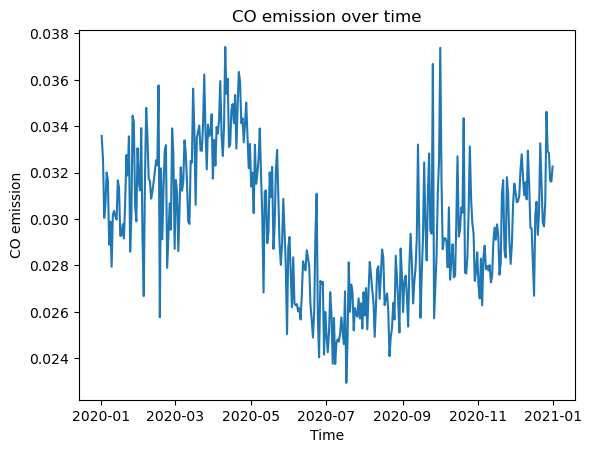

In [59]:
plt.plot(co_data["start_time"], co_data['avg_emission'])
plt.title('CO emission over time')
plt.xlabel('Time')
plt.ylabel('CO emission')

Text(0, 0.5, 'Cases')

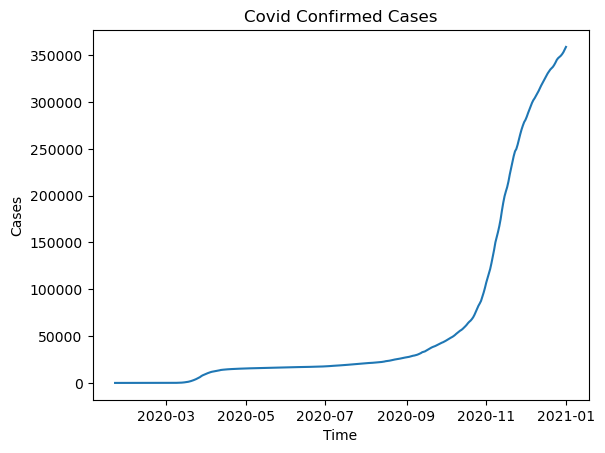

In [58]:
# covid_df["Date"] = covid_df["Date"].apply(lambda d: pd.to_datetime(str(d)))
plt.plot(covid_df["created_at"], covid_df['cases'])
plt.title('Covid Confirmed Cases')
plt.xlabel('Time')
plt.ylabel('Cases')

In [52]:
# plt.plot(covid_df["Date"], co_df['average'], label="co")
# plt.plot(covid_df["Date"], covid_df['Cases'], label="covid")
# plt.xlabel('Time')

In [53]:
# spark = SparkSession.builder.getOrCreate()
# sc = spark.sparkContext
# rddjson = sc.parallelize(jsonStr)
# covid_df2 = spark.read.json(rddjson)
# covid_df2